
╔══════════════════════════════════════════════════════════════════════════════╗
║                     SYSTÈME DE COUVERTURE CONNEXE MINIMUM                    ║
║                        Glouton + VNS + Recherche Tabou                       ║
╚══════════════════════════════════════════════════════════════════════════════╝


████████████████████████████████████████████████████████████████████████████████
█                                 EXPÉRIENCE 1 :                               █
████████████████████████████████████████████████████████████████████████████████
📂 Chargement: grille1010_2.dat (format: grille_tronquee)
   ✓ 90 cibles + 1 puits chargés

╔══════════════════════════════════════════════════════════════════════════════╗
║  INSTANCE : Grille 10x10 - 2 tronquée                                        ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Nombre de cibles : 90                                                       ║
║  Rayon captat

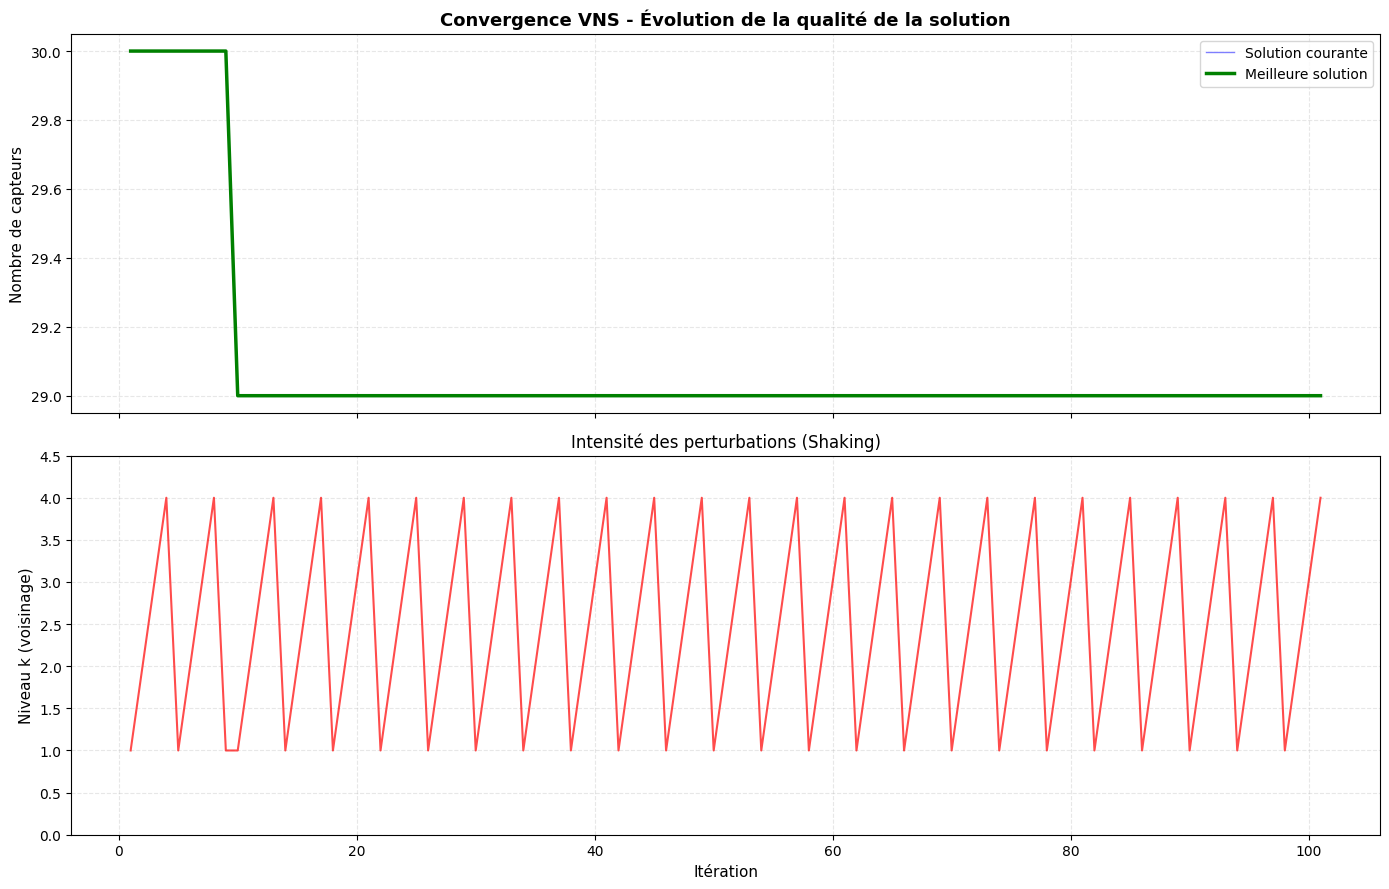

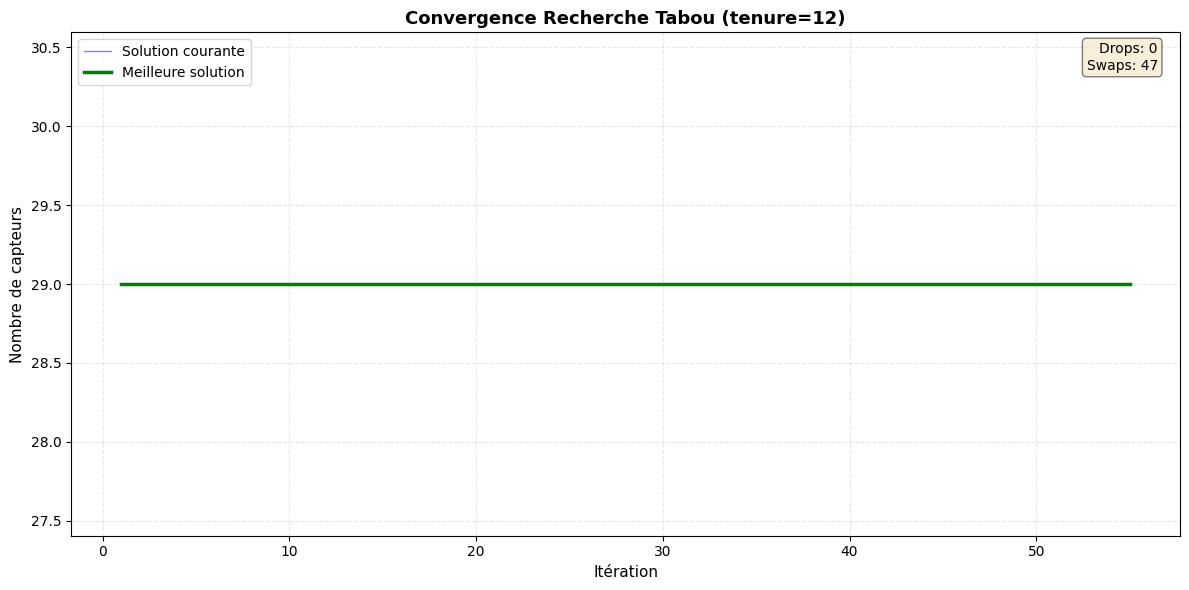

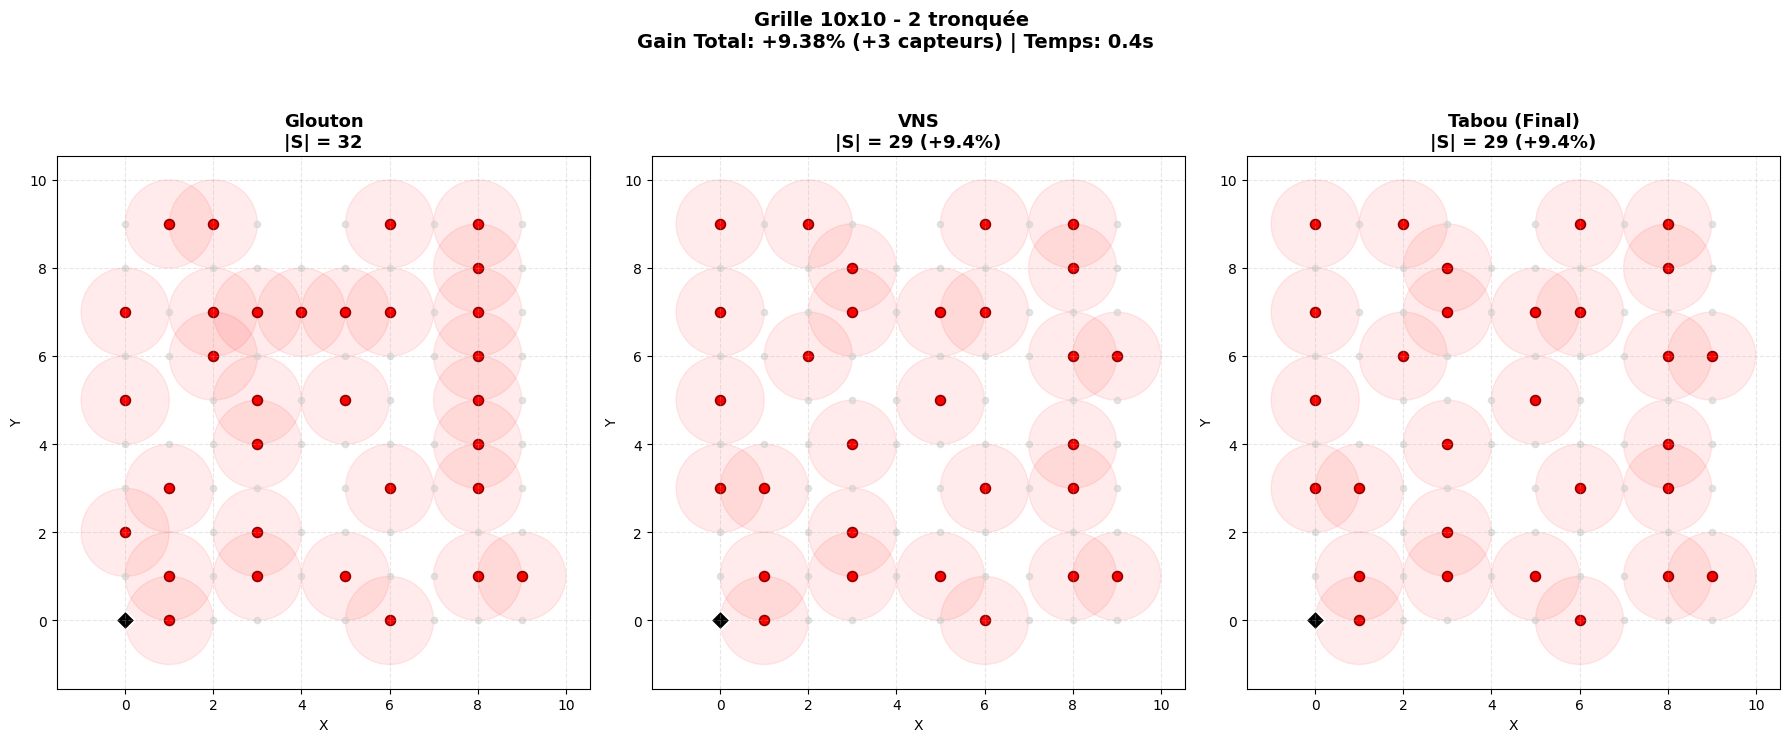



████████████████████████████████████████████████████████████████████████████████
█                      EXPÉRIENCE 2 : GRILLE 30x30 tronquée                    █
████████████████████████████████████████████████████████████████████████████████
📂 Chargement: grille3030_1.dat (format: grille_tronquee)
   ✓ 669 cibles + 1 puits chargés

╔══════════════════════════════════════════════════════════════════════════════╗
║  INSTANCE : Grille 30x30 tronquée                                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Nombre de cibles : 669                                                      ║
║  Rayon captation  : R_capt = 1                                               ║
║  Rayon communication : R_com = 2                                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌──────────────────────────────────────────────────────────────────────────────┐
│  ⏱️  PARAMÈT

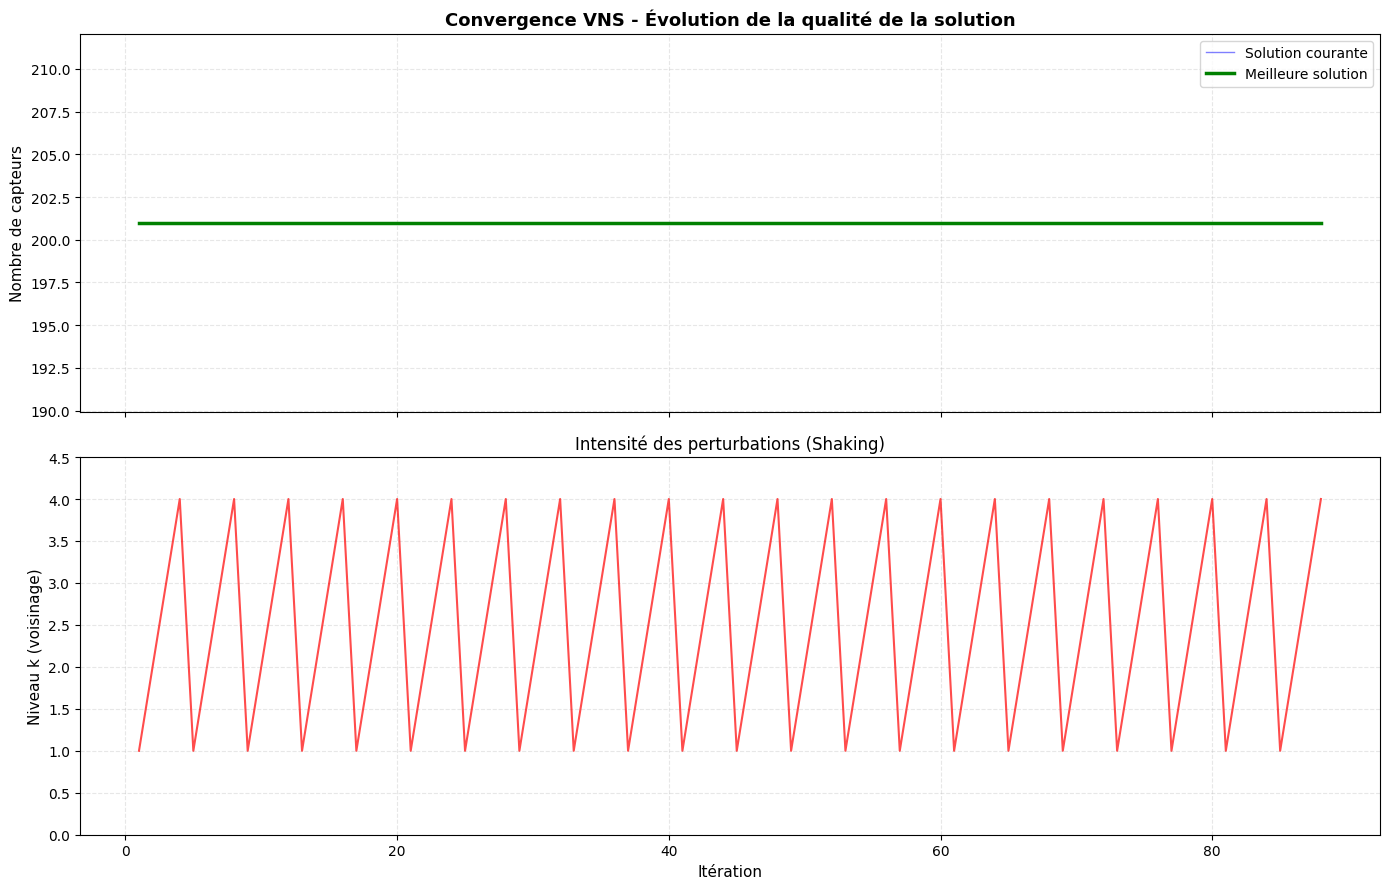

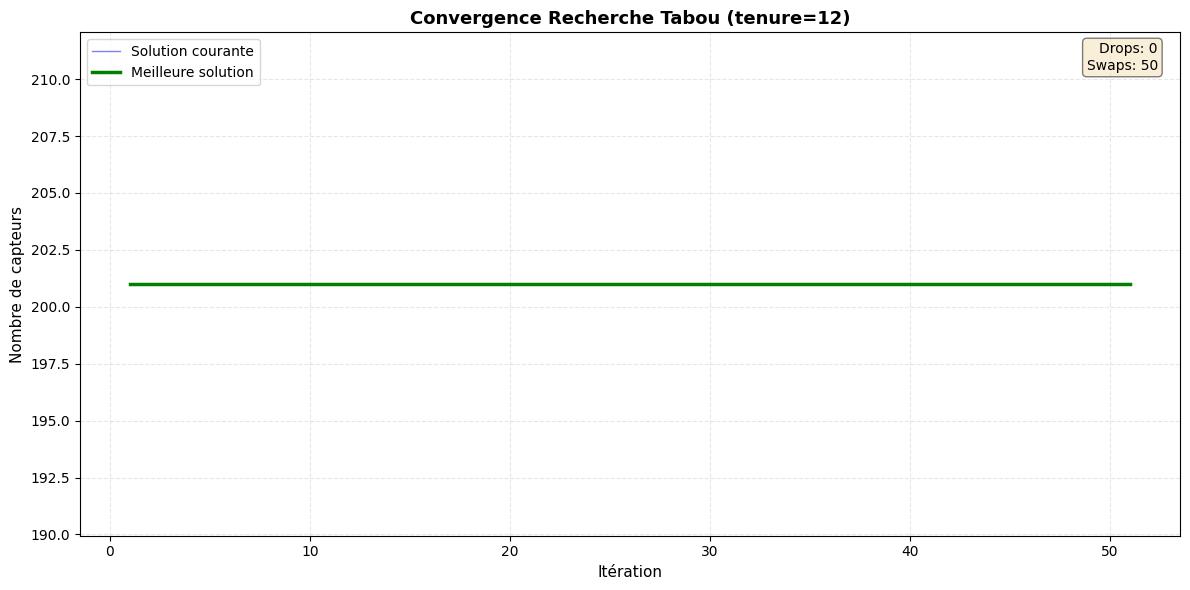

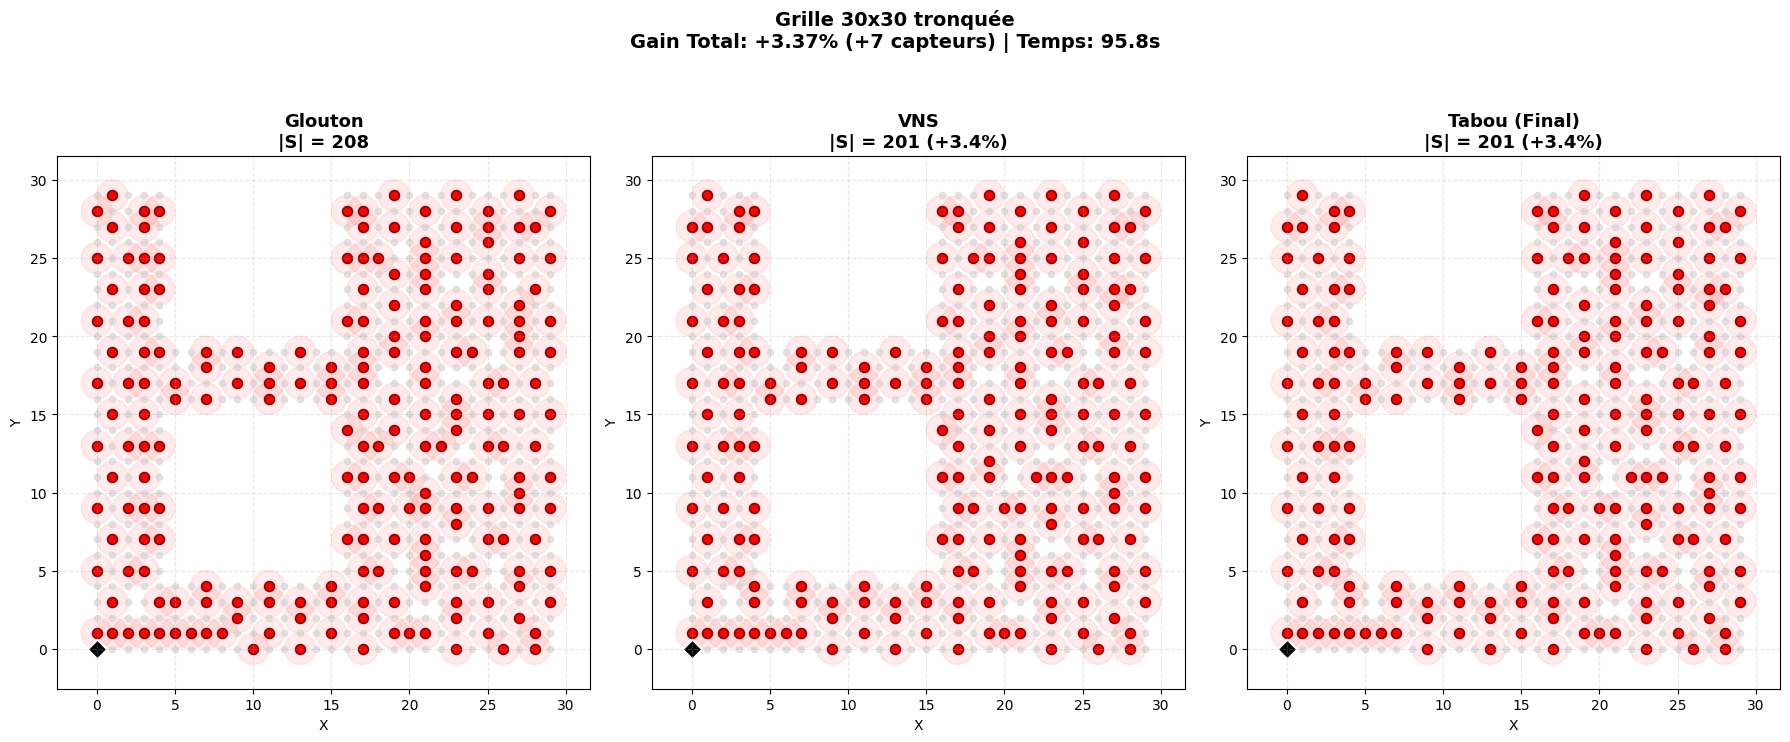



████████████████████████████████████████████████████████████████████████████████
█                    EXPÉRIENCE 4 : POINTS ALÉATOIRES 16_100                   █
████████████████████████████████████████████████████████████████████████████████
📂 Chargement: captANOR1600_16_100_2021.dat (format: points_aleatoires)
   ✓ 1600 cibles + 1 puits chargés

╔══════════════════════════════════════════════════════════════════════════════╗
║  INSTANCE : Points Aléatoires                                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Nombre de cibles : 1600                                                     ║
║  Rayon captation  : R_capt = 1                                               ║
║  Rayon communication : R_com = 2                                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌──────────────────────────────────────────────────────────────────────────────┐

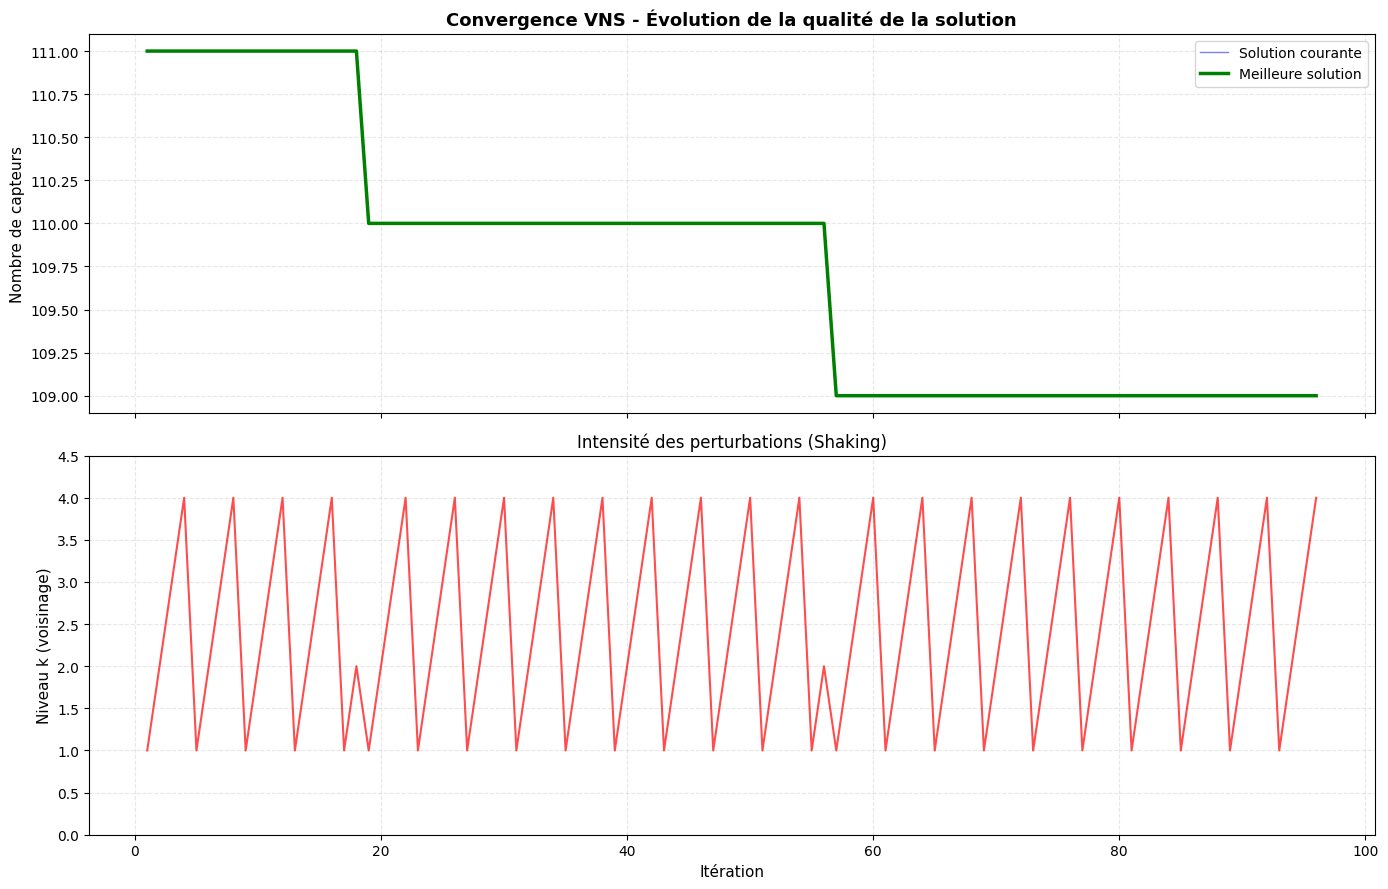

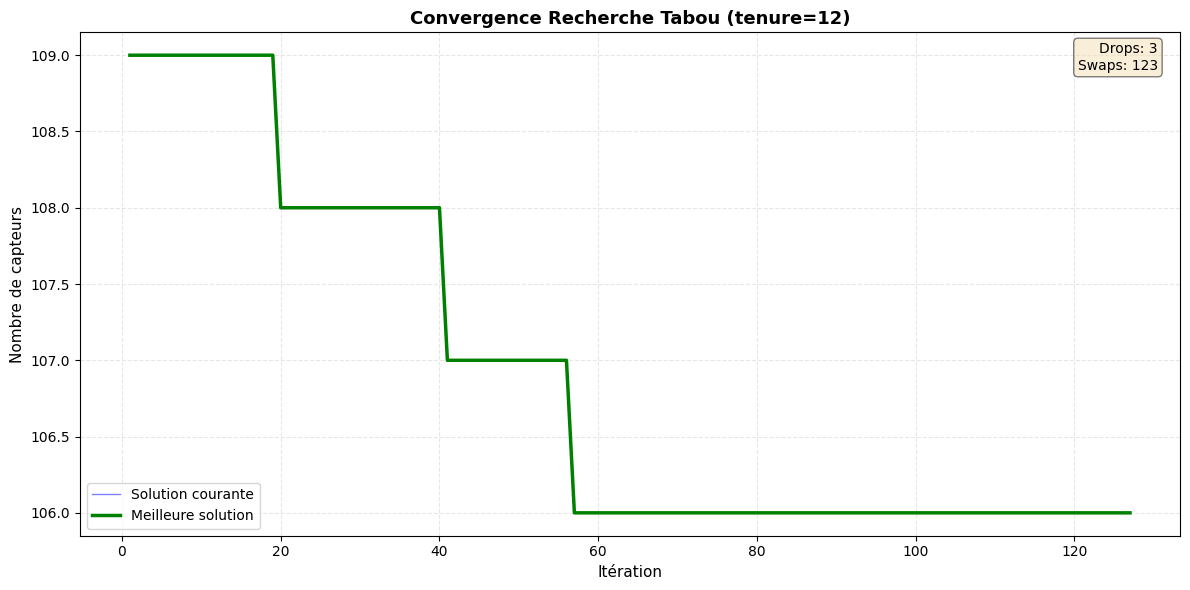

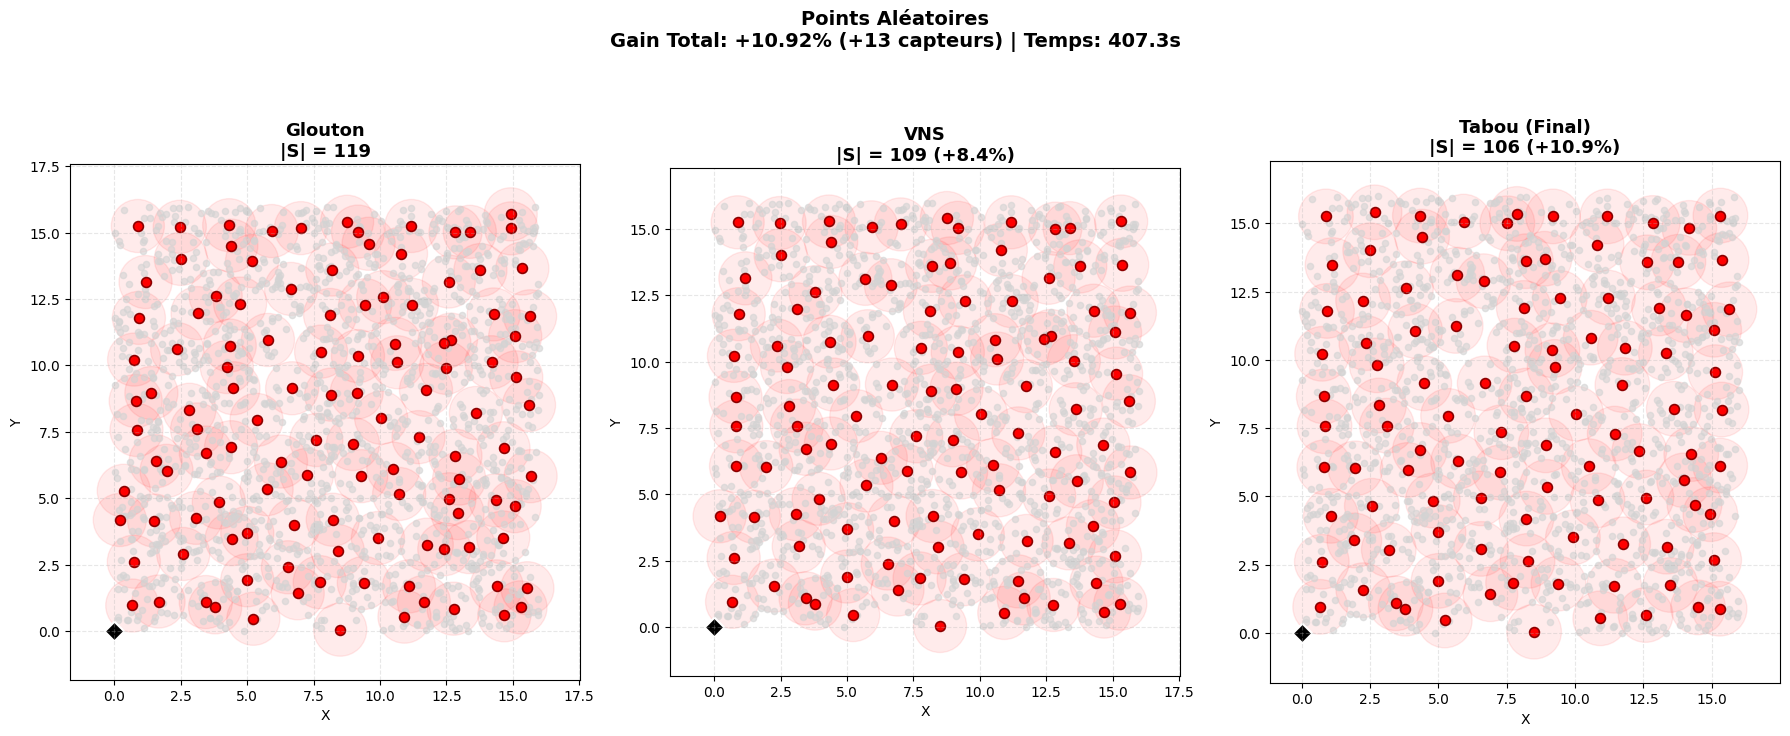



╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                           📊 TABLEAU RÉCAPITULATIF GLOBAL - COMPARAISON EXPÉRIMENTALE                         ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
║  Instance             Cibles   |S|_Glout  |S|_VNS   |S|_Tabou  Gain(%)    Temps(s)   Valide                  ║
╟──────────────────────────────────────────────────────────────────────────────────────────────────────────────╢
║  Grille 10x10 - 2 tronquée  90       32         29        29           +9.38%   0.4        ✓                 ║
║  Grille 30x30 tronquée 669      208        201       201          +3.37%   95.8       ✓                      ║
║  Points Aléatoires    1600     119        109       106         +10.92%   407.3      ✓                       ║
╠═════════════════════════════════════════════════════════════════════════════════════════════

In [ ]:
"""
================================================================================
COUVERTURE CONNEXE MINIMUM DANS LES RÉSEAUX DE CAPTEURS
Heuristique Gloutonne Améliorée + Variable Neighborhood Search (VNS) + Tabou
================================================================================
"""

import math
import re
import os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
from typing import Dict, Set, Tuple, List, Optional
import numpy as np

# =============================================================================
# PARAMÈTRES GLOBAUX
# =============================================================================
R_CAPT = 1
R_COM = 2
PUITS_X = 0
PUITS_Y = 0


# =============================================================================
# MODULE 1 : PARSERS DE FICHIERS
# =============================================================================

def detecter_format(chemin: str) -> str:
    """Détecte le format du fichier : 'grille_tronquee' ou 'points_aleatoires'."""
    with open(chemin, 'r', encoding='utf-8') as f:
        contenu = f.read().lower()
    
    if 'taille de la grille' in contenu or ':=' in contenu:
        return 'grille_tronquee'
    return 'points_aleatoires'


def parser_grille_tronquee(chemin: str, puits: Tuple[float, float] = (0, 0)) -> Dict[int, Tuple[float, float]]:
    """Parse un fichier de grille tronquée."""
    with open(chemin, 'r', encoding='utf-8') as f:
        contenu = f.read()
    
    match = re.search(r'taille de la grille compl[èe]te\s*:=\s*(\d+)', contenu, re.IGNORECASE)
    if not match:
        raise ValueError("Taille de grille non trouvée")
    
    taille = int(match.group(1))
    cote = int(math.sqrt(taille))
    
    supprimes = set()
    for m in re.findall(r'\d+\s*:\s*\((\d+),\s*(\d+)\)', contenu):
        supprimes.add((int(m[0]), int(m[1])))
    
    points = {0: puits}
    id_point = 1
    for y in range(cote):
        for x in range(cote):
            if (x, y) not in supprimes:
                points[id_point] = (float(x), float(y))
                id_point += 1
    
    return points

def parser_points_aleatoires(chemin: str, puits: Tuple[float, float] = (0, 0)) -> Dict[int, Tuple[float, float]]:
    """Parse un fichier de points aléatoires."""
    with open(chemin, 'r', encoding='utf-8') as f:
        lignes = f.readlines()
    
    points_lus = {}
    for ligne in lignes:
        match = re.match(r'^\s*(\d+)\s+([\d.]+)\s+([\d.]+)', ligne.strip())
        if match:
            id_p = int(match.group(1))
            x, y = float(match.group(2)), float(match.group(3))
            points_lus[id_p] = (x, y)
    
    if 0 in points_lus:
        return points_lus
    else:
        points = {0: puits}
        for id_p, coord in points_lus.items():
            points[id_p + 1] = coord
        return points

def charger_instance(chemin: str, puits: Tuple[float, float] = (0, 0)) -> Dict[int, Tuple[float, float]]:
    """Charge un fichier et retourne les points."""
    if not os.path.exists(chemin):
        raise FileNotFoundError(f"Fichier non trouvé: {chemin}")
    
    fmt = detecter_format(chemin)
    print(f"📂 Chargement: {os.path.basename(chemin)} (format: {fmt})")
    
    if fmt == 'grille_tronquee':
        points = parser_grille_tronquee(chemin, puits)
    else:
        points = parser_points_aleatoires(chemin, puits)
    
    print(f"   ✓ {len(points) - 1} cibles + 1 puits chargés")
    return points



# =============================================================================
# MODULE 2 : RÉSEAU DE CAPTEURS (Structures de données)
# =============================================================================

class ReseauCapteurs:
    """Gère le réseau avec pré-calcul des adjacences."""
    
    def __init__(self, points: Dict[int, Tuple[float, float]], r_capt: float, r_com: float):
        self.points = points
        self.r_capt = r_capt
        self.r_com = r_com
        self.id_puits = 0
        self.cibles = set(points.keys()) - {0}
        
        # Bornes pour affichage
        xs, ys = zip(*points.values())
        self.x_min, self.x_max = min(xs), max(xs)
        self.y_min, self.y_max = min(ys), max(ys)
        
        # Pré-calcul adjacences
        self._calculer_adjacences()
    
    def _distance(self, id1: int, id2: int) -> float:
        x1, y1 = self.points[id1]
        x2, y2 = self.points[id2]
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    def _calculer_adjacences(self):
        """Pré-calcule voisins de captation et communication."""
        self.voisins_capt: Dict[int, List[int]] = {}
        self.voisins_com: Dict[int, List[int]] = {}
        
        tous_ids = list(self.points.keys())
        
        for i in self.cibles:
            self.voisins_capt[i] = [j for j in self.cibles if self._distance(i, j) <= self.r_capt]
            self.voisins_com[i] = [j for j in tous_ids if i != j and self._distance(i, j) <= self.r_com]
        
        self.voisins_com[0] = [j for j in self.cibles if self._distance(0, j) <= self.r_com]
    
    def cibles_couvertes(self, capteur: int) -> List[int]:
        return self.voisins_capt.get(capteur, [])
    
    def voisins_communication(self, noeud: int) -> List[int]:
        return self.voisins_com.get(noeud, [])


# =============================================================================
# MODULE 3 : HEURISTIQUE GLOUTONNE AMÉLIORÉE
# =============================================================================

class HeuristiqueGloutonneAmelioree:
    """
    Heuristique Gloutonne avec stratégie de frontière intelligente.
    
    Améliorations intégrées:
    - Look-Ahead: Score basé sur gain + proximité au barycentre des cibles non couvertes
    - Pruning: Nettoyage final pour supprimer les capteurs redondants
    """
    
    def __init__(self, reseau: ReseauCapteurs, alpha: float = 0.4, epsilon: float = 1e-6):
        self.reseau = reseau
        self.alpha = alpha
        self.epsilon = epsilon
    
    def _calculer_barycentre(self, cibles_non_couvertes: Set[int]) -> Tuple[float, float]:
        if not cibles_non_couvertes:
            return ((self.reseau.x_min + self.reseau.x_max) / 2,
                    (self.reseau.y_min + self.reseau.y_max) / 2)
        
        x_sum, y_sum = 0.0, 0.0
        for cible in cibles_non_couvertes:
            x, y = self.reseau.points[cible]
            x_sum += x
            y_sum += y
        
        n = len(cibles_non_couvertes)
        return (x_sum / n, y_sum / n)
    
    def _distance_au_barycentre(self, capteur: int, barycentre: Tuple[float, float]) -> float:
        x_capt, y_capt = self.reseau.points[capteur]
        x_bary, y_bary = barycentre
        return math.sqrt((x_capt - x_bary)**2 + (y_capt - y_bary)**2)
    
    def _nettoyage_final(self, solution: Set[int], verbose: bool = False) -> Set[int]:
        solution_nettoyee = solution.copy()
        capteurs_supprimes = 0
        
        capteurs_tries = sorted(
            list(solution_nettoyee),
            key=lambda c: len([cib for cib in self.reseau.cibles_couvertes(c) 
                              if cib in self.reseau.cibles])
        )
        
        for capteur in capteurs_tries:
            if capteur not in solution_nettoyee:
                continue
            
            solution_test = solution_nettoyee - {capteur}
            
            if self._est_valide(solution_test):
                solution_nettoyee = solution_test
                capteurs_supprimes += 1
        
        if verbose and capteurs_supprimes > 0:
            print(f"    🧹 Nettoyage: {capteurs_supprimes} capteurs redondants supprimés")
        
        return solution_nettoyee
    
    def _est_valide(self, solution: Set[int]) -> bool:
        if not solution:
            return False
        
        cibles_couvertes: Set[int] = set()
        for capteur in solution:
            cibles_couvertes.update(self.reseau.cibles_couvertes(capteur))
        
        if not self.reseau.cibles.issubset(cibles_couvertes):
            return False
        
        actifs_avec_puits = solution | {0}
        visite = {0}
        file = deque([0])
        
        while file:
            courant = file.popleft()
            for voisin in self.reseau.voisins_communication(courant):
                if voisin in actifs_avec_puits and voisin not in visite:
                    visite.add(voisin)
                    file.append(voisin)
        
        return solution.issubset(visite)
    
    def resoudre(self, verbose: bool = True) -> Set[int]:
        if verbose:
            print("\n⚙️  Résolution Gloutonne Améliorée...")
            print(f"    R_capt={self.reseau.r_capt}, R_com={self.reseau.r_com}")
        
        solution_capteurs = [0]
        cibles_couvertes: Set[int] = set()
        
        for c in self.reseau.cibles_couvertes(0):
            cibles_couvertes.add(c)
        
        frontiere: Set[int] = set(self.reseau.voisins_communication(0))
        frontiere.discard(0)
        
        nb_total_cibles = len(self.reseau.cibles)
        iteration = 0
        
        while len(cibles_couvertes) < nb_total_cibles:
            iteration += 1
            
            if not frontiere:
                if verbose:
                    print("    ⚠️  Blocage : Impossible de couvrir plus de cibles (graphe déconnecté)")
                break
            
            cibles_non_couvertes = self.reseau.cibles - cibles_couvertes
            barycentre = self._calculer_barycentre(cibles_non_couvertes)
            
            meilleur_candidat = None
            meilleur_score = -float('inf')
            candidats_liste = list(frontiere)
            
            for candidat in candidats_liste:
                gain = 0
                for cible in self.reseau.cibles_couvertes(candidat):
                    if cible not in cibles_couvertes:
                        gain += 1
                
                dist_bary = self._distance_au_barycentre(candidat, barycentre)
                score = gain + (self.alpha / (dist_bary + self.epsilon))
                
                if score > meilleur_score:
                    meilleur_score = score
                    meilleur_candidat = candidat
            
            if meilleur_candidat is None:
                meilleur_candidat = candidats_liste[0]
            
            solution_capteurs.append(meilleur_candidat)
            
            for c in self.reseau.cibles_couvertes(meilleur_candidat):
                cibles_couvertes.add(c)
            
            frontiere.remove(meilleur_candidat)
            for voisin in self.reseau.voisins_communication(meilleur_candidat):
                if voisin not in solution_capteurs and voisin not in frontiere:
                    frontiere.add(voisin)
            
            if verbose and iteration % 50 == 0:
                print(f"    Iter {iteration}: {len(solution_capteurs)} capteurs, "
                      f"{len(cibles_couvertes)}/{nb_total_cibles} cibles")
        
        solution_set = set(solution_capteurs) - {0}
        
        if verbose:
            print(f"    ✓ Construction terminée : {len(solution_set)} capteurs")
        
        taille_avant = len(solution_set)
        solution_set = self._nettoyage_final(solution_set, verbose=verbose)
        
        if verbose:
            print(f"    ✓ Couverture : {len(cibles_couvertes)}/{nb_total_cibles} cibles")
            if len(solution_set) < taille_avant:
                print(f"    ✓ Après nettoyage : {len(solution_set)} capteurs "
                      f"(-{taille_avant - len(solution_set)})")
        
        return solution_set


# =============================================================================
# MODULE 4 : VARIABLE NEIGHBORHOOD SEARCH (VNS)
# =============================================================================

class VariableNeighborhoodSearch:
    """VNS Optimisé pour le problème de Couverture Connexe Minimum."""
    
    def __init__(self, reseau: ReseauCapteurs, k_max: int = 4, max_iter: int = 100, 
                 max_time: float = 60.0, max_iter_sans_amelioration: int = 80, seed: Optional[int] = None):
        self.reseau = reseau
        self.k_max = k_max
        self.max_iter = max_iter
        self.max_time = max_time
        self.max_iter_sans_amelioration = max_iter_sans_amelioration
        if seed: random.seed(seed)
        
        self.stats = {'shakes': 0, 'local_search_calls': 0, 'ameliorations': 0, 'bfs_saved': 0}
        self.historique_taille = []
        self.historique_meilleur = []
        self.historique_k = []

    def est_valide(self, solution: Set[int], check_connectivity: bool = True) -> bool:
        if not solution: return False
        
        cibles_couvertes = set()
        for capteur in solution:
            cibles_couvertes.update(self.reseau.cibles_couvertes(capteur))
        
        if not self.reseau.cibles.issubset(cibles_couvertes):
            return False
            
        if not check_connectivity:
            return True

        actifs_avec_puits = solution | {0}
        visite = {0}
        file = deque([0])
        count = 0 
        target_len = len(actifs_avec_puits)
        
        while file:
            courant = file.popleft()
            count += 1
            for voisin in self.reseau.voisins_communication(courant):
                if voisin in actifs_avec_puits and voisin not in visite:
                    visite.add(voisin)
                    file.append(voisin)
        
        return count == target_len

    def fitness(self, solution: Set[int]) -> float:
        return len(solution)
    
    def shake(self, solution: Set[int], k: int) -> Set[int]:
        self.stats['shakes'] += 1
        if k == 1: return self._shake_smart_swap(solution)
        elif k == 2: return self._shake_add_redundancy(solution)
        elif k == 3: return self._shake_long_jump(solution)
        else: return self._shake_ruin_recreate(solution)

    def _shake_smart_swap(self, solution: Set[int]) -> Set[int]:
        if not solution: return set()
        nouv = solution.copy()
        c = random.choice(list(nouv))
        voisins = [v for v in self.reseau.voisins_communication(c) if v not in nouv and v != 0]
        if voisins:
            nouv.remove(c)
            nouv.add(random.choice(voisins))
        return nouv

    def _shake_add_redundancy(self, solution: Set[int]) -> Set[int]:
        nouv = solution.copy()
        actifs = list(nouv | {0})
        pivot = random.choice(actifs)
        candidats = [v for v in self.reseau.voisins_communication(pivot) if v not in nouv and v != 0]
        if candidats: nouv.add(random.choice(candidats))
        return nouv

    def _shake_long_jump(self, solution: Set[int]) -> Set[int]:
        return self._shake_smart_swap(self._shake_smart_swap(solution))

    def _shake_ruin_recreate(self, solution: Set[int]) -> Set[int]:
        if len(solution) < 5: return self._shake_long_jump(solution)
        nouv = solution.copy()
        center = random.choice(list(nouv))
        to_remove = {center}
        for v in self.reseau.voisins_communication(center):
            if v in nouv: to_remove.add(v)
        nouv -= to_remove
        return self._reparer_solution(nouv, to_remove)
    
    def _reparer_solution(self, solution: Set[int], zone_detruite: Set[int]) -> Set[int]:
        solution_reparee = solution.copy()
        solution_reparee = self._reparer_connexite(solution_reparee, zone_detruite)
        solution_reparee = self._reparer_couverture(solution_reparee, zone_detruite)
        return solution_reparee
    
    def _reparer_connexite(self, solution: Set[int], candidats_prioritaires: Set[int]) -> Set[int]:
        solution_reparee = solution.copy()
        
        while True:
            actifs = solution_reparee | {0}
            composante_puits = {0}
            file = deque([0])
            
            while file:
                courant = file.popleft()
                for voisin in self.reseau.voisins_communication(courant):
                    if voisin in actifs and voisin not in composante_puits:
                        composante_puits.add(voisin)
                        file.append(voisin)
            
            isoles = solution_reparee - composante_puits
            
            if not isoles:
                break
            
            meilleur_chemin = None
            
            for iso in isoles:
                chemin = self._bfs_chemin(iso, composante_puits)
                if chemin is not None:
                    if meilleur_chemin is None or len(chemin) < len(meilleur_chemin):
                        meilleur_chemin = chemin
            
            if meilleur_chemin is None:
                for candidat in candidats_prioritaires:
                    if candidat not in solution_reparee:
                        solution_reparee.add(candidat)
                        break
                else:
                    break
            else:
                for relais in meilleur_chemin:
                    if relais not in solution_reparee and relais != 0:
                        solution_reparee.add(relais)
        
        return solution_reparee
    
    def _bfs_chemin(self, source: int, destinations: Set[int]) -> Optional[List[int]]:
        if source in destinations:
            return []
        
        pred = {source: None}
        file = deque([source])
        arrivee = None
        
        while file and arrivee is None:
            courant = file.popleft()
            for v in self.reseau.voisins_communication(courant):
                if v not in pred:
                    pred[v] = courant
                    if v in destinations:
                        arrivee = v
                        break
                    file.append(v)
        
        if arrivee is None:
            return None
        
        chemin = []
        c = arrivee
        while pred[c] is not None:
            if c != arrivee:
                chemin.append(c)
            c = pred[c]
        return chemin
    
    def _reparer_couverture(self, solution: Set[int], candidats_prioritaires: Set[int]) -> Set[int]:
        solution_reparee = solution.copy()
        
        cibles_couvertes: Set[int] = set()
        for capteur in solution_reparee:
            cibles_couvertes.update(self.reseau.cibles_couvertes(capteur))
        
        cibles_manquantes = self.reseau.cibles - cibles_couvertes
        
        while cibles_manquantes:
            meilleur_candidat = None
            meilleur_gain = 0
            
            for candidat in candidats_prioritaires:
                if candidat in solution_reparee:
                    continue
                est_connecte = any(
                    candidat in self.reseau.voisins_communication(c)
                    for c in (solution_reparee | {0})
                )
                if not est_connecte:
                    continue
                
                gain = len(set(self.reseau.cibles_couvertes(candidat)) & cibles_manquantes)
                if gain > meilleur_gain:
                    meilleur_gain = gain
                    meilleur_candidat = candidat
            
            if meilleur_candidat is None:
                for capteur in solution_reparee | {0}:
                    for voisin in self.reseau.voisins_communication(capteur):
                        if voisin in solution_reparee or voisin == 0:
                            continue
                        gain = len(set(self.reseau.cibles_couvertes(voisin)) & cibles_manquantes)
                        if gain > meilleur_gain:
                            meilleur_gain = gain
                            meilleur_candidat = voisin
            
            if meilleur_candidat is None:
                break
            
            solution_reparee.add(meilleur_candidat)
            candidats_prioritaires.discard(meilleur_candidat)
            
            for c in self.reseau.cibles_couvertes(meilleur_candidat):
                cibles_couvertes.add(c)
            cibles_manquantes = self.reseau.cibles - cibles_couvertes
        
        return solution_reparee
    
    def local_search(self, solution: Set[int], mode: str = 'best') -> Set[int]:
        self.stats['local_search_calls'] += 1
        
        courante = solution.copy()
        ameliore = True
        
        while ameliore:
            ameliore = False
            meilleure_suppression = None
            
            for capteur in list(courante):
                candidate = courante - {capteur}
                
                if self.est_valide(candidate):
                    if mode == 'first':
                        courante = candidate
                        ameliore = True
                        break
                    else:
                        meilleure_suppression = capteur
            
            if mode == 'best' and meilleure_suppression is not None:
                courante.remove(meilleure_suppression)
                ameliore = True
        
        return courante
    
    def local_search_intensif(self, solution: Set[int]) -> Set[int]:
        courante = solution.copy()
        courante = self.local_search(courante, mode='best')
        
        ameliore = True
        while ameliore:
            ameliore = False
            
            for capteur in list(courante):
                voisins_inactifs = [
                    v for v in self.reseau.voisins_communication(capteur)
                    if v not in courante and v != 0
                ]
                
                for nouveau in voisins_inactifs:
                    candidate = (courante - {capteur}) | {nouveau}
                    
                    if self.est_valide(candidate):
                        candidate_optimisee = self.local_search(candidate, mode='first')
                        
                        if len(candidate_optimisee) < len(courante):
                            courante = candidate_optimisee
                            ameliore = True
                            break
                
                if ameliore:
                    break
        
        return courante
    
    def run(self, solution_initiale: Set[int], verbose: bool = True, intensif: bool = False) -> Set[int]:
        if verbose:
            print("\n" + "="*70)
            print("🔍 VARIABLE NEIGHBORHOOD SEARCH (VNS)")
            print("="*70)
            print(f"   ⏱️  [CONTRÔLE TEMPS] max_time     = {self.max_time}s")
            print(f"   🔄 [CONTRÔLE ITER]  max_iter     = {self.max_iter}")
            print(f"   🛑 [ARRÊT PRÉCOCE]  sans_amélio  = {self.max_iter_sans_amelioration}")
            print(f"   📊 [VOISINAGES]     k_max        = {self.k_max}")
            print("="*70)
        
        temps_debut = time.time()
        
        if intensif:
            solution = self.local_search_intensif(solution_initiale.copy())
        else:
            solution = self.local_search(solution_initiale.copy())
        
        best_ever = solution.copy()
        fitness_best = self.fitness(best_ever)
        
        if verbose:
            print(f"\n   Solution initiale optimisée: {len(solution)} capteurs")
        
        iteration = 0
        iter_sans_amelioration = 0
        
        while iteration < self.max_iter:
            temps_ecoule = time.time() - temps_debut
            if temps_ecoule >= self.max_time:
                if verbose:
                    print(f"\n   ⏱️  Arrêt: temps limite atteint ({temps_ecoule:.1f}s)")
                break
            
            if iter_sans_amelioration >= self.max_iter_sans_amelioration:
                if verbose:
                    print(f"\n   🛑 Arrêt: {self.max_iter_sans_amelioration} iter sans amélioration")
                break
            
            k = 1
            amelioration_trouvee = False
            
            while k <= self.k_max:
                iteration += 1
                
                solution_perturbee = self.shake(solution, k)
                
                if intensif:
                    solution_optimisee = self.local_search_intensif(solution_perturbee)
                else:
                    solution_optimisee = self.local_search(solution_perturbee)
                
                fitness_nouvelle = self.fitness(solution_optimisee)
                
                self.historique_taille.append(len(solution))
                self.historique_meilleur.append(len(best_ever))
                self.historique_k.append(k)
                
                if fitness_nouvelle < self.fitness(solution):
                    solution = solution_optimisee
                    k = 1
                    amelioration_trouvee = True
                    
                    if fitness_nouvelle < fitness_best:
                        best_ever = solution.copy()
                        fitness_best = fitness_nouvelle
                        iter_sans_amelioration = 0
                        self.stats['ameliorations'] += 1
                        
                        if verbose:
                            print(f"   ★ Iter {iteration:4d} (k={k}): Nouveau best: "
                                  f"{len(best_ever)} capteurs")
                else:
                    k += 1
            
            if not amelioration_trouvee:
                iter_sans_amelioration += 1
            
            if verbose and iteration % 50 == 0:
                temps_ecoule = time.time() - temps_debut
                print(f"   → Iter {iteration:4d}: {len(solution)} capteurs "
                      f"(best: {len(best_ever)}, temps: {temps_ecoule:.1f}s)")
        
        temps_total = time.time() - temps_debut
        self.temps_total = temps_total
        self.iterations_totales = iteration
        
        if verbose:
            print("\n" + "-"*70)
            print(f"✅ RÉSULTAT VNS: {len(best_ever)} capteurs")
            print(f"   Temps: {temps_total:.2f}s | Itérations: {iteration}")
            print(f"   Stats: Shakes={self.stats['shakes']}, "
                  f"LS={self.stats['local_search_calls']}, "
                  f"Améliorations={self.stats['ameliorations']}")
            print("-"*70)
        
        return best_ever
    
    def afficher_convergence(self):
        if not self.historique_taille:
            print("Pas d'historique à afficher")
            return
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=True)
        iterations = range(1, len(self.historique_taille) + 1)
        
        ax1 = axes[0]
        ax1.plot(iterations, self.historique_taille, 'b-', alpha=0.5, label='Solution courante', linewidth=1)
        ax1.plot(iterations, self.historique_meilleur, 'g-', linewidth=2.5, label='Meilleure solution')
        ax1.set_ylabel('Nombre de capteurs', fontsize=11)
        ax1.set_title('Convergence VNS - Évolution de la qualité de la solution', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        ax2 = axes[1]
        ax2.plot(iterations, self.historique_k, 'r-', alpha=0.7, linewidth=1.5)
        ax2.set_xlabel('Itération', fontsize=11)
        ax2.set_ylabel('Niveau k (voisinage)', fontsize=11)
        ax2.set_ylim(0, self.k_max + 0.5)
        ax2.set_title('Intensité des perturbations (Shaking)', fontsize=12)
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()


# =============================================================================
# MODULE 4bis : RECHERCHE TABOU (Tabu Search)
# =============================================================================

class TabuSearch:
    """Recherche Tabou avec Time-Out."""
    
    def __init__(self,
                 reseau: ReseauCapteurs,
                 tenure: int = 10,
                 max_iterations: int = 200,
                 max_time: float = 60.0,
                 max_iter_sans_amelioration: int = 50,
                 seed: Optional[int] = None):
        
        self.reseau = reseau
        self.tenure = tenure
        self.max_iterations = max_iterations
        self.max_time = max_time
        self.max_iter_sans_amelioration = max_iter_sans_amelioration
        
        if seed is not None:
            random.seed(seed)
        
        self.liste_taboue: Dict[int, int] = {}
        self.historique_taille: List[int] = []
        self.historique_meilleur: List[int] = []
        self.stats = {
            'drops_reussis': 0, 'swaps_effectues': 0, 
            'aspirations': 0, 'iterations_totales': 0
        }
        self.temps_total = 0.0

    def est_valide(self, solution: Set[int]) -> bool:
        if not solution:
            return False
        
        cibles_couvertes: Set[int] = set()
        for capteur in solution:
            cibles_couvertes.update(self.reseau.cibles_couvertes(capteur))
        
        if not self.reseau.cibles.issubset(cibles_couvertes):
            return False
        
        actifs_avec_puits = solution | {0}
        visite = {0}
        file = deque([0])
        
        while file:
            courant = file.popleft()
            for v in self.reseau.voisins_communication(courant):
                if v in actifs_avec_puits and v not in visite:
                    visite.add(v)
                    file.append(v)
        
        return solution.issubset(visite)

    def est_tabou(self, capteur: int, iteration: int) -> bool:
        return capteur in self.liste_taboue and self.liste_taboue[capteur] > iteration

    def ajouter_tabou(self, capteur: int, iteration: int):
        self.liste_taboue[capteur] = iteration + self.tenure

    def calculer_robustesse(self, solution: Set[int]) -> float:
        if not solution: return 0.0
        couverture_par_cible = {c: 0 for c in self.reseau.cibles}
        for capteur in solution:
            for cible in self.reseau.cibles_couvertes(capteur):
                if cible in couverture_par_cible: couverture_par_cible[cible] += 1
        redondance = sum(couverture_par_cible.values()) / len(self.reseau.cibles)
        degre_total = 0
        actifs = solution | {0}
        for c in solution:
            degre_total += sum(1 for v in self.reseau.voisins_communication(c) if v in actifs)
        connectivite = degre_total / len(solution) if solution else 0
        return redondance + 0.5 * connectivite

    def trouver_meilleur_drop(self, solution: Set[int], iteration: int) -> Optional[int]:
        meilleur, best_rob = None, -float('inf')
        for capteur in solution:
            test = solution - {capteur}
            if self.est_valide(test):
                rob = self.calculer_robustesse(test)
                if rob > best_rob: meilleur, best_rob = capteur, rob
        return meilleur

    def trouver_meilleur_swap(self, solution: Set[int], iteration: int, best_global: int):
        meilleur_swap, best_rob = None, -float('inf')
        for c_actif in solution:
            voisins = [v for v in self.reseau.voisins_communication(c_actif) 
                       if v not in solution and v != 0]
            for c_new in voisins:
                test = (solution - {c_actif}) | {c_new}
                if not self.est_valide(test): continue
                
                rob = self.calculer_robustesse(test)
                is_tabu = self.est_tabou(c_actif, iteration)
                aspiration = len(test) < best_global
                
                if is_tabu and not aspiration: continue
                
                if meilleur_swap is None or rob > best_rob:
                    meilleur_swap = (c_actif, c_new, rob)
                    best_rob = rob
                    if is_tabu and aspiration: self.stats['aspirations'] += 1
        return meilleur_swap

    def run(self, solution_initiale: Set[int], verbose: bool = True) -> Set[int]:
        if verbose:
            print("\n" + "="*70)
            print("🔒 RECHERCHE TABOU (Tabu Search)")
            print("="*70)
            print(f"   ⏱️  [CONTRÔLE TEMPS] max_time     = {self.max_time}s")
            print(f"   🔄 [CONTRÔLE ITER]  max_iter     = {self.max_iterations}")
            print(f"   🛑 [ARRÊT PRÉCOCE]  sans_amélio  = {self.max_iter_sans_amelioration}")
            print(f"   🔐 [TENURE TABOU]   tenure       = {self.tenure}")
            print("="*70)
        
        temps_debut = time.time()
        
        solution_courante = solution_initiale.copy()
        meilleure_solution = solution_courante.copy()
        meilleure_fitness = len(meilleure_solution)
        
        iteration = 0
        iter_sans_amelioration = 0
        
        while iteration < self.max_iterations:
            if time.time() - temps_debut > self.max_time:
                if verbose:
                    print(f"\n   ⏱️ Arrêt Tabou : temps limite atteint ({self.max_time}s)")
                break

            iteration += 1
            self.stats['iterations_totales'] += 1
            
            self.historique_taille.append(len(solution_courante))
            self.historique_meilleur.append(meilleure_fitness)
            
            if iter_sans_amelioration >= self.max_iter_sans_amelioration:
                if verbose: print(f"\n   🛑 Arrêt: {self.max_iter_sans_amelioration} iter sans amélio")
                break
            
            mouvement_effectue = False
            
            capteur_drop = self.trouver_meilleur_drop(solution_courante, iteration)
            if capteur_drop is not None:
                solution_courante.remove(capteur_drop)
                self.ajouter_tabou(capteur_drop, iteration)
                self.stats['drops_reussis'] += 1
                mouvement_effectue = True
                
                if len(solution_courante) < meilleure_fitness:
                    meilleure_solution = solution_courante.copy()
                    meilleure_fitness = len(meilleure_solution)
                    iter_sans_amelioration = 0
                    if verbose: print(f"   ★ Iter {iteration}: DROP -> {meilleure_fitness} capteurs")
                else:
                    iter_sans_amelioration += 1
            else:
                swap = self.trouver_meilleur_swap(solution_courante, iteration, meilleure_fitness)
                if swap:
                    rem, add, _ = swap
                    solution_courante.remove(rem)
                    solution_courante.add(add)
                    self.ajouter_tabou(rem, iteration)
                    self.stats['swaps_effectues'] += 1
                    mouvement_effectue = True
                    
                    if len(solution_courante) < meilleure_fitness:
                        meilleure_solution = solution_courante.copy()
                        meilleure_fitness = len(meilleure_solution)
                        iter_sans_amelioration = 0
                        if verbose: print(f"   ★ Iter {iteration}: SWAP -> {meilleure_fitness} capteurs")
                    else:
                        iter_sans_amelioration += 1
                else:
                    iter_sans_amelioration += 1
            
            if not mouvement_effectue:
                iter_sans_amelioration += 1
        
        self.temps_total = time.time() - temps_debut
        
        if verbose:
            print("\n" + "-"*70)
            print(f"✅ RÉSULTAT TABOU: {meilleure_fitness} capteurs")
            print(f"   Temps: {self.temps_total:.2f}s | Itérations: {iteration}")
            print(f"   Stats: Drops={self.stats['drops_reussis']}, "
                  f"Swaps={self.stats['swaps_effectues']}, "
                  f"Aspirations={self.stats['aspirations']}")
            print("-"*70)
        
        return meilleure_solution

    def afficher_convergence(self):
        if not self.historique_taille:
            print("Pas d'historique à afficher")
            return
        
        fig, ax = plt.subplots(figsize=(12, 6))
        iterations = range(1, len(self.historique_taille) + 1)
        
        ax.plot(iterations, self.historique_taille, 'b-', alpha=0.5, 
                label='Solution courante', linewidth=1)
        ax.plot(iterations, self.historique_meilleur, 'g-', linewidth=2.5, 
                label='Meilleure solution')
        
        ax.set_xlabel('Itération', fontsize=11)
        ax.set_ylabel('Nombre de capteurs', fontsize=11)
        ax.set_title(f'Convergence Recherche Tabou (tenure={self.tenure})', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        textstr = f"Drops: {self.stats['drops_reussis']}\nSwaps: {self.stats['swaps_effectues']}"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=props)
        
        plt.tight_layout()
        plt.show()


# =============================================================================
# MODULE 5 : VÉRIFICATION ET VISUALISATION
# =============================================================================

def verifier_solution(solution: Set[int], reseau: ReseauCapteurs, verbose: bool = True) -> bool:
    if verbose:
        print("\n🔎 [Vérification de la solution]")
    
    valide = True
    
    couvertes: Set[int] = set()
    for c in solution:
        couvertes.update(reseau.cibles_couvertes(c))
    
    manquantes = reseau.cibles - couvertes
    if manquantes:
        if verbose:
            print(f"   ✗ {len(manquantes)} cibles non couvertes")
        valide = False
    else:
        if verbose:
            print(f"   ✓ Toutes les {len(reseau.cibles)} cibles couvertes")
    
    actifs = solution | {0}
    visite = {0}
    file = deque([0])
    while file:
        c = file.popleft()
        for v in reseau.voisins_communication(c):
            if v in actifs and v not in visite:
                visite.add(v)
                file.append(v)
    
    non_connectes = solution - visite
    if non_connectes:
        if verbose:
            print(f"   ✗ {len(non_connectes)} capteurs non connectés au puits")
        valide = False
    else:
        if verbose:
            print(f"   ✓ Tous les capteurs connectés au puits")
    
    return valide


def visualiser(solution: Set[int], reseau: ReseauCapteurs, titre: str = ""):
    fig, ax = plt.subplots(figsize=(14, 11))
    
    x_puits, y_puits = reseau.points[0]
    x_actifs, y_actifs = [], []
    x_inactifs, y_inactifs = [], []
    
    for i in reseau.cibles:
        x, y = reseau.points[i]
        if i in solution:
            x_actifs.append(x)
            y_actifs.append(y)
        else:
            x_inactifs.append(x)
            y_inactifs.append(y)
    
    noeuds = list(solution) + [0]
    for i, u in enumerate(noeuds):
        for v in noeuds[i+1:]:
            if reseau._distance(u, v) <= reseau.r_com:
                xu, yu = reseau.points[u]
                xv, yv = reseau.points[v]
                ax.plot([xu, xv], [yu, yv], 'g-', alpha=0.25, lw=1)
    
    for c in solution:
        x, y = reseau.points[c]
        cercle = patches.Circle((x, y), reseau.r_capt, color='red', alpha=0.08, zorder=1)
        ax.add_patch(cercle)
    
    ax.scatter(x_inactifs, y_inactifs, c='lightgrey', s=25, label='Cibles', zorder=2, alpha=0.6)
    ax.scatter(x_actifs, y_actifs, c='red', s=60, edgecolors='darkred', linewidths=1.5, 
               label='Capteurs actifs', zorder=3)
    ax.scatter([x_puits], [y_puits], c='black', marker='D', s=120, 
               label='Puits', zorder=4, edgecolors='white', linewidths=1.5)
    
    ax.set_aspect('equal')
    marge = max(reseau.r_capt, reseau.r_com) * 1.2
    ax.set_xlim(reseau.x_min - marge, reseau.x_max + marge)
    ax.set_ylim(reseau.y_min - marge, reseau.y_max + marge)
    
    titre_final = titre or "Réseau de Capteurs Sans Fil"
    titre_final += f"\n{len(solution)} capteurs (R_capt={reseau.r_capt}, R_com={reseau.r_com})"
    plt.title(titre_final, fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, ls='--', alpha=0.4)
    plt.xlabel("Coordonnée X", fontsize=11)
    plt.ylabel("Coordonnée Y", fontsize=11)
    plt.tight_layout()
    plt.show()


# =============================================================================
# MODULE 6 : COMPARAISON COMPLÈTE (Améliorée avec Tabou)
# =============================================================================

def comparer_methodes(points: Dict[int, Tuple[float, float]],
                      r_capt: float = R_CAPT,
                      r_com: float = R_COM,
                      # --- PARAMÈTRES VNS ---
                      vns_k_max: int = 4,
                      vns_max_iter: int = 100,
                      vns_max_time: float = 60.0,
                      vns_max_sans_amelio: int = 80,
                      # --- PARAMÈTRES TABOU ---
                      tabou_tenure: int = 10,
                      tabou_max_iter: int = 200,
                      tabou_max_time: float = 60.0,
                      tabou_max_sans_amelio: int = 50,
                      # --- OPTIONS ---
                      afficher: bool = True,
                      titre_instance: str = "") -> Dict:
    """
    Compare les 3 méthodes : Glouton, VNS et Recherche Tabou.
    """
    
    # =========================================================================
    # EN-TÊTE DE L'INSTANCE
    # =========================================================================
    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + f"  INSTANCE : {titre_instance}".ljust(78) + "║")
    print("╠" + "═"*78 + "╣")
    print("║" + f"  Nombre de cibles : {len(points)-1}".ljust(78) + "║")
    print("║" + f"  Rayon captation  : R_capt = {r_capt}".ljust(78) + "║")
    print("║" + f"  Rayon communication : R_com = {r_com}".ljust(78) + "║")
    print("╚" + "═"*78 + "╝")
    
    # =========================================================================
    # AFFICHAGE DES PARAMÈTRES DE CONTRÔLE DU TEMPS
    # =========================================================================
    print("\n" + "┌" + "─"*78 + "┐")
    print("│" + "  ⏱️  PARAMÈTRES DE CONTRÔLE DU TEMPS DE CALCUL".ljust(78) + "│")
    print("├" + "─"*78 + "┤")
    print("│" + f"  [VNS]   max_time={vns_max_time}s | max_iter={vns_max_iter} | sans_amélio={vns_max_sans_amelio}".ljust(78) + "│")
    print("│" + f"  [TABOU] max_time={tabou_max_time}s | max_iter={tabou_max_iter} | sans_amélio={tabou_max_sans_amelio}".ljust(78) + "│")
    print("└" + "─"*78 + "┘")
    
    reseau = ReseauCapteurs(points, r_capt, r_com)
    
    # =========================================================================
    # PHASE 1 : HEURISTIQUE GLOUTONNE
    # =========================================================================
    print("\n" + "─"*80)
    print("📊 PHASE 1 : HEURISTIQUE GLOUTONNE AMÉLIORÉE")
    print("─"*80)
    
    t0 = time.time()
    heuristique = HeuristiqueGloutonneAmelioree(reseau)
    solution_glouton = heuristique.resoudre(verbose=True)
    temps_glouton = time.time() - t0
    valide_glouton = verifier_solution(solution_glouton, reseau, verbose=False)
    
    # =========================================================================
    # PHASE 2 : VNS
    # =========================================================================
    print("\n" + "─"*80)
    print("🔍 PHASE 2 : VARIABLE NEIGHBORHOOD SEARCH (VNS)")
    print("─"*80)
    
    t0 = time.time()
    vns = VariableNeighborhoodSearch(
        reseau=reseau,
        k_max=vns_k_max,
        max_iter=vns_max_iter,
        max_time=vns_max_time,
        max_iter_sans_amelioration=vns_max_sans_amelio
    )
    solution_vns = vns.run(solution_initiale=solution_glouton, verbose=True, intensif=True)
    temps_vns = time.time() - t0
    valide_vns = verifier_solution(solution_vns, reseau, verbose=False)
    
    # =========================================================================
    # PHASE 3 : RECHERCHE TABOU
    # =========================================================================
    print("\n" + "─"*80)
    print("🔒 PHASE 3 : RECHERCHE TABOU")
    print("─"*80)
    
    t0 = time.time()
    tabou = TabuSearch(
        reseau=reseau,
        tenure=tabou_tenure,
        max_iterations=tabou_max_iter,
        max_time=tabou_max_time,
        max_iter_sans_amelioration=tabou_max_sans_amelio
    )
    solution_tabou = tabou.run(solution_initiale=solution_vns, verbose=True)
    temps_tabou = time.time() - t0
    valide_tabou = verifier_solution(solution_tabou, reseau, verbose=False)
    
    # =========================================================================
    # CALCUL DES MÉTRIQUES
    # =========================================================================
    S_glouton = len(solution_glouton)
    S_vns = len(solution_vns)
    S_tabou = len(solution_tabou)
    S_final = S_tabou  # Solution finale = après Tabou
    
    gain_vns_vs_glouton = S_glouton - S_vns
    gain_vns_pct = (gain_vns_vs_glouton / S_glouton * 100) if S_glouton > 0 else 0
    
    gain_tabou_vs_vns = S_vns - S_tabou
    gain_tabou_pct = (gain_tabou_vs_vns / S_vns * 100) if S_vns > 0 else 0
    
    gain_total = S_glouton - S_final
    gain_total_pct = (gain_total / S_glouton * 100) if S_glouton > 0 else 0
    
    temps_total = temps_glouton + temps_vns + temps_tabou
    
    # =========================================================================
    # TABLEAU RÉCAPITULATIF DÉTAILLÉ
    # =========================================================================
    print("\n")
    print("╔" + "═"*78 + "╗")
    print("║" + "  📋 RÉSULTATS DÉTAILLÉS DE L'INSTANCE".center(78) + "║")
    print("╠" + "═"*78 + "╣")
    
    # Ligne d'en-tête
    print("║" + f"  {'Méthode':<20} {'|S|':<8} {'Valide':<8} {'Temps(s)':<10} {'Gain vs préc.':<15} {'Gain vs Glouton':<15}" + "║")
    print("╟" + "─"*78 + "╢")
    
    # Glouton
    print("║" + f"  {'Glouton':<20} {S_glouton:<8} {'✓' if valide_glouton else '✗':<8} {temps_glouton:<10.3f} {'—':<15} {'—':<15}" + "║")
    
    # VNS
    gain_vns_str = f"{gain_vns_vs_glouton:+d} ({gain_vns_pct:+.1f}%)"
    print("║" + f"  {'VNS':<20} {S_vns:<8} {'✓' if valide_vns else '✗':<8} {temps_vns:<10.3f} {gain_vns_str:<15} {gain_vns_str:<15}" + "║")
    
    # Tabou
    gain_tabou_str = f"{gain_tabou_vs_vns:+d} ({gain_tabou_pct:+.1f}%)"
    gain_total_str = f"{gain_total:+d} ({gain_total_pct:+.1f}%)"
    print("║" + f"  {'Tabou':<20} {S_tabou:<8} {'✓' if valide_tabou else '✗':<8} {temps_tabou:<10.3f} {gain_tabou_str:<15} {gain_total_str:<15}" + "║")
    
    print("╠" + "═"*78 + "╣")
    
    # Résumé
    print("║" + f"  📊 RÉSUMÉ :".ljust(78) + "║")
    print("║" + f"     • |S|_Glouton = {S_glouton}".ljust(78) + "║")
    print("║" + f"     • |S|_VNS     = {S_vns}".ljust(78) + "║")
    print("║" + f"     • |S|_Tabou   = {S_tabou} (Solution Finale)".ljust(78) + "║")
    print("║" + f"     • Gain Total  = {gain_total} capteurs ({gain_total_pct:+.2f}%)".ljust(78) + "║")
    print("║" + f"     • Temps Total = {temps_total:.2f}s".ljust(78) + "║")
    print("║" + f"     • Validité    = {'✓ VALIDE' if valide_tabou else '✗ INVALIDE'}".ljust(78) + "║")
    
    print("╚" + "═"*78 + "╝")
    
    # =========================================================================
    # STATISTIQUES DÉTAILLÉES
    # =========================================================================
    print("\n┌" + "─"*78 + "┐")
    print("│" + "  📈 STATISTIQUES DÉTAILLÉES".ljust(78) + "│")
    print("├" + "─"*78 + "┤")
    print("│" + f"  [VNS]   Shakes: {vns.stats['shakes']} | LS: {vns.stats['local_search_calls']} | Améliorations: {vns.stats['ameliorations']}".ljust(78) + "│")
    print("│" + f"  [TABOU] Drops: {tabou.stats['drops_reussis']} | Swaps: {tabou.stats['swaps_effectues']} | Aspirations: {tabou.stats['aspirations']}".ljust(78) + "│")
    print("│" + f"  [TABOU] Itérations: {tabou.stats['iterations_totales']}".ljust(78) + "│")
    print("└" + "─"*78 + "┘")
    
    # =========================================================================
    # VISUALISATIONS
    # =========================================================================
    if afficher:
        vns.afficher_convergence()
        tabou.afficher_convergence()
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 8))
        
        solutions_a_afficher = [
            (axes[0], solution_glouton, f"Glouton\n|S| = {S_glouton}"),
            (axes[1], solution_vns, f"VNS\n|S| = {S_vns} ({gain_vns_pct:+.1f}%)"),
            (axes[2], solution_tabou, f"Tabou (Final)\n|S| = {S_tabou} ({gain_total_pct:+.1f}%)")
        ]
        
        for ax, sol, methode in solutions_a_afficher:
            x_puits, y_puits = reseau.points[0]
            x_actifs = [reseau.points[i][0] for i in sol]
            y_actifs = [reseau.points[i][1] for i in sol]
            x_inactifs = [reseau.points[i][0] for i in reseau.cibles - sol]
            y_inactifs = [reseau.points[i][1] for i in reseau.cibles - sol]
            
            for c in sol:
                x, y = reseau.points[c]
                cercle = patches.Circle((x, y), r_capt, color='red', alpha=0.08)
                ax.add_patch(cercle)
            
            ax.scatter(x_inactifs, y_inactifs, c='lightgrey', s=20, alpha=0.6)
            ax.scatter(x_actifs, y_actifs, c='red', s=50, edgecolors='darkred', linewidths=1.2)
            ax.scatter([x_puits], [y_puits], c='black', marker='D', s=100, 
                      edgecolors='white', linewidths=1.5)
            
            ax.set_aspect('equal')
            ax.set_title(methode, fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_xlabel('X', fontsize=10)
            ax.set_ylabel('Y', fontsize=10)
        
        plt.suptitle(f"{titre_instance}\nGain Total: {gain_total_pct:+.2f}% ({gain_total:+d} capteurs) | Temps: {temps_total:.1f}s",
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # =========================================================================
    # RETOUR DES RÉSULTATS
    # =========================================================================
    return {
        'instance': titre_instance,
        'nb_cibles': len(points) - 1,
        'r_capt': r_capt,
        'r_com': r_com,
        'glouton': {
            'solution': solution_glouton,
            'nb_capteurs': S_glouton,
            'valide': valide_glouton,
            'temps': temps_glouton
        },
        'vns': {
            'solution': solution_vns,
            'nb_capteurs': S_vns,
            'valide': valide_vns,
            'temps': temps_vns,
            'gain_vs_glouton': gain_vns_vs_glouton,
            'gain_vs_glouton_pct': gain_vns_pct,
            'stats': vns.stats
        },
        'tabou': {
            'solution': solution_tabou,
            'nb_capteurs': S_tabou,
            'valide': valide_tabou,
            'temps': temps_tabou,
            'gain_vs_vns': gain_tabou_vs_vns,
            'gain_vs_vns_pct': gain_tabou_pct,
            'stats': tabou.stats
        },
        'final': {
            'nb_capteurs': S_final,
            'gain_total': gain_total,
            'gain_total_pct': gain_total_pct,
            'temps_total': temps_total,
            'valide': valide_tabou
        }
    }


# =============================================================================
# MODULE 7 : EXPÉRIMENTATIONS
# =============================================================================

if __name__ == "__main__":
    
    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + "  SYSTÈME DE COUVERTURE CONNEXE MINIMUM".center(78) + "║")
    print("║" + "  Glouton + VNS + Recherche Tabou".center(78) + "║")
    print("╚" + "═"*78 + "╝")
    
    # Liste pour stocker tous les résultats
    tous_resultats = []
    
    # =========================================================================
    # EXPÉRIENCE 1 : 
    # =========================================================================
    print("\n\n" + "█"*80)
    print("█" + "  EXPÉRIENCE 1 :".center(78) + "█")
    print("█"*80)
    chemin_grille1 = r"Projet de métaheuristiques - Instances grilles tronquées\grille1010_2.dat"
    points_tronquee1 = charger_instance(chemin_grille1)
    
    resultats_1 = comparer_methodes(
        points_tronquee1,
        r_capt=R_CAPT, r_com=R_COM,
        # Paramètres VNS
        vns_k_max=4, vns_max_iter=100, vns_max_time=50.0, vns_max_sans_amelio=70,
        # Paramètres Tabou
        tabou_tenure=12, tabou_max_iter=250, tabou_max_time=300.0, tabou_max_sans_amelio=60,
        afficher=True,
        titre_instance="Grille 10x10 - 2 tronquée "
    )
    tous_resultats.append(resultats_1)
    
    # =========================================================================
    # EXPÉRIENCE 2 : GRILLE 15x15
    # =========================================================================
    print("\n\n" + "█"*80)
    print("█" + "  EXPÉRIENCE 2 : GRILLE 30x30 tronquée".center(78) + "█")
    print("█"*80)
    chemin_grille2 = r"Projet de métaheuristiques - Instances grilles tronquées\grille3030_1.dat"
    points_tronquee2 = charger_instance(chemin_grille2)
    
    resultats_2 = comparer_methodes(
        points_tronquee2,
        r_capt=R_CAPT, r_com=R_COM,
        # Paramètres VNS
        vns_k_max=4, vns_max_iter=150, vns_max_time=80.0, vns_max_sans_amelio=60,
        # Paramètres Tabou
        tabou_tenure=12, tabou_max_iter=200, tabou_max_time=80.0, tabou_max_sans_amelio=50,
        afficher=True,
        titre_instance="Grille 30x30 tronquée"
    )
    tous_resultats.append(resultats_2)
    
    # =========================================================================
    # EXPÉRIENCE 3 : aléa
    # =========================================================================
    chemin_grille_alea = r"Projet de métaheuristiques - Instances cibles générées aléatoirement/captANOR900_14_20_2021.dat"
    
    if  os.path.exists(chemin_grille_alea):
        print("\n\n" + "█"*80)
        print("█" + "  EXPÉRIENCE 3 : GRILLE Aléatoire 14_20".center(78) + "█")
        print("█"*80)
        
        points_tronquee = charger_instance(chemin_grille_alea)
        resultats_3 = comparer_methodes(
            points_tronquee,
            r_capt=R_CAPT, r_com=R_COM,
            # Paramètres VNS
            vns_k_max=4, vns_max_iter=300, vns_max_time=220.0, vns_max_sans_amelio=80,
            # Paramètres Tabou
            tabou_tenure=12, tabou_max_iter=500, tabou_max_time=220.0, tabou_max_sans_amelio=100,
            afficher=True,
            titre_instance="Grille Aléa 14_20"
        )
        tous_resultats.append(resultats_3)
    
    # =========================================================================
    # EXPÉRIENCE 4 : POINTS ALÉATOIRES
    # =========================================================================
    chemin_aleatoire = r"Projet de métaheuristiques - Instances cibles générées aléatoirement/captANOR1600_16_100_2021.dat"
    
    if os.path.exists(chemin_aleatoire):
        print("\n\n" + "█"*80)
        print("█" + "  EXPÉRIENCE 4 : POINTS ALÉATOIRES 16_100".center(78) + "█")
        print("█"*80)
        
        points_aleatoires = charger_instance(chemin_aleatoire)
        resultats_4 = comparer_methodes(
            points_aleatoires,
            r_capt=R_CAPT, r_com=R_COM,
            # Paramètres VNS
            vns_k_max=4, vns_max_iter=400, vns_max_time=260.0, vns_max_sans_amelio=100,
            # Paramètres Tabou
            tabou_tenure=12, tabou_max_iter=220, tabou_max_time=180.0, tabou_max_sans_amelio=70,
            afficher=True,
            titre_instance="Points Aléatoires"
        )
        tous_resultats.append(resultats_4)
    
    # =========================================================================
    # TABLEAU RÉCAPITULATIF GLOBAL
    # =========================================================================
    print("\n\n" + "╔" + "═"*110 + "╗")
    print("║" + "  📊 TABLEAU RÉCAPITULATIF GLOBAL - COMPARAISON EXPÉRIMENTALE".center(110) + "║")
    print("╠" + "═"*110 + "╣")
    
    # En-tête
    header = f"  {'Instance':<20} {'Cibles':<8} {'|S|_Glout':<10} {'|S|_VNS':<9} {'|S|_Tabou':<10} {'Gain(%)':<10} {'Temps(s)':<10} {'Valide':<8}"
    print("║" + header.ljust(110) + "║")
    print("╟" + "─"*110 + "╢")
    
    # Lignes de données
    for res in tous_resultats:
        ligne = f"  {res['instance']:<20} {res['nb_cibles']:<8} {res['glouton']['nb_capteurs']:<10} {res['vns']['nb_capteurs']:<9} {res['tabou']['nb_capteurs']:<10} {res['final']['gain_total_pct']:>+7.2f}%   {res['final']['temps_total']:<10.1f} {'✓' if res['final']['valide'] else '✗':<8}"
        print("║" + ligne.ljust(110) + "║")
    
    print("╠" + "═"*110 + "╣")
    
    # Moyennes
    if tous_resultats:
        moy_gain = sum(r['final']['gain_total_pct'] for r in tous_resultats) / len(tous_resultats)
        moy_temps = sum(r['final']['temps_total'] for r in tous_resultats) / len(tous_resultats)
        total_capteurs_eco = sum(r['final']['gain_total'] for r in tous_resultats)
        
        print("║" + f"  📈 MOYENNES ET TOTAUX :".ljust(110) + "║")
        print("║" + f"     • Gain moyen (Glouton → Tabou) : {moy_gain:+.2f}%".ljust(110) + "║")
        print("║" + f"     • Temps moyen par instance     : {moy_temps:.1f}s".ljust(110) + "║")
        print("║" + f"     • Total capteurs économisés    : {total_capteurs_eco}".ljust(110) + "║")
    
    print("╚" + "═"*110 + "╝")
    
    # =========================================================================
    # TABLEAU DÉTAILLÉ PAR PHASE
    # =========================================================================
    print("\n" + "┌" + "─"*110 + "┐")
    print("│" + "  📋 DÉTAIL DES GAINS PAR PHASE".center(110) + "│")
    print("├" + "─"*110 + "┤")
    
    header2 = f"  {'Instance':<20} {'Glouton→VNS':<18} {'VNS→Tabou':<18} {'Temps Glout':<12} {'Temps VNS':<12} {'Temps Tabou':<12}"
    print("│" + header2.ljust(110) + "│")
    print("├" + "─"*110 + "┤")
    
    for res in tous_resultats:
        gain_vns = f"{res['vns']['gain_vs_glouton']:+d} ({res['vns']['gain_vs_glouton_pct']:+.1f}%)"
        gain_tabou = f"{res['tabou']['gain_vs_vns']:+d} ({res['tabou']['gain_vs_vns_pct']:+.1f}%)"
        ligne = f"  {res['instance']:<20} {gain_vns:<18} {gain_tabou:<18} {res['glouton']['temps']:<12.2f} {res['vns']['temps']:<12.2f} {res['tabou']['temps']:<12.2f}"
        print("│" + ligne.ljust(110) + "│")
    
    print("└" + "─"*110 + "┘")
    
    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + "  FIN DES EXPÉRIENCES".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")